### 二阶模型
转子运动方程
$\left\{\begin{array}{l}{\frac{d \Delta \omega}{d t}=\left(P_{m}-P_{e}\right) / T_{J}}\qquad &P_m&=1\\ {\frac{d \delta}{d t}=\Delta \omega \omega_{B}} \qquad&\Delta\omega&=\omega-1,\,\omega_{B}=314rad/s \end{array}\right.$  


<font color=#0099ff>由上，𝑡𝑛~𝑡𝑛+1时步的差分方程为</font>  
$\left\{\begin{aligned} q_{\omega}&=\Delta \omega_{n+1}-\Delta \omega_{n}-\frac{h}{2 T_{J}}\left[\left(P_{m, n+1}-P_{e, n+1}\right)+\left(P_{m, n}-P_{e, n}\right)\right]=0 \\ q_{\delta}&=\delta_{n+1}-\delta_{n}-\frac{\omega_{B} h}{2}\left(\Delta \omega_{n+1}+\Delta \omega_{n}\right)=0 \end{aligned}\right.$

<font color=#0099ff>其中</font>
$P_{e, n+1}=\left.\left(E_{q, n+1}^{\prime} i_{q, n+1}-\left(X_{d, n+1}^{\prime}-X_{q, n+1}\right) i_{d, n+1} i_{q, n+1}\right)\right|_{t_{n+1}}$  
$P_{e, n+1}=Re(\dot E^{\prime}{I}^{*})$  
<font color=#0099ff>节点导纳电压方程</font>
$I = YU$  
设初始状态<font color=#ff00ff>平衡节点电压</font>与<font color=#008873>发电机电流</font><font color=#ff0000>同相位</font>

In [47]:
tuple({dw:-dw,delta:314*dw}.keys())[0]
(dw+1).subs({x:1,dw:1})
sy.diff(x**3,x)

3*x**2

<img src="power_system_example.png" width="70%">  
$\small \begin{align*}G-1:\quad x_{d}&=0.1, &x_{2}&=0.1, &T_{J}&=10 s \\ 
G-2:\quad x_{d}^{\prime}&=0.15, &x_{2}&=0.15,  &T_{J}&=7 s \\
G-3:\quad x_{d}^{\prime}&=0.06, &x_{2}&=0.06, &T_{J}&=15 s\end{align*}$  
变压器电抗$:\, x_{T 1}=0.08, \quad x_{T 2}=0.1, \quad x_{T 3}=0.04, \quad x_{T 4}=0.05$    
线路电抗：AB段双回$x_{L1}=0.2,x_{L0}=3.5x_{L1}$；BC段双回$x_{L1}=0.1,x_{L0}=3.5x_{L1}$  
系统的初始状态：$V_{D0}=1.0,S_{LD0}=5.5+j1.25,S_{20}=1.0+j0.5,S_{30}=3.0+j0.8$  
**扰动事件描述：在线路AB段首端点发生两相短路接地，经切除故障线路。**

In [1]:
import numpy as np
import pandas as pd
import sympy as sy
import time
from scipy.linalg import solve
import matplotlib.pyplot as plt
sy.init_printing(use_latex=True)
%matplotlib inline

### hiding-trapezium method 隐式梯形法

In [65]:
# def subs(func, value):
#     '''将表达式用value字典替换'''
#     if type(func) in (int,float):
#         return func
#     elif callable(func):
#         return func(*value.values())
#     else:
#         return func.subs(value)
    
# def newton_laphson(derivative, iter_values, e=0.00001, h=0.02, co_vars=None):
#     '''
#     牛顿拉夫逊法
#     parameters
#     ==========
#     derivative 导数构成的字典
#     init_values 导数中待求解变量的初始值,其中元素个数与导数个数相同
#     h 步长
#     e 收敛满足max(|F(n+1)-Fn|) < e
#     '''
#     #初始化  
# #     iter_values = {key:value for key,value in zip(derivative.keys(),init_values)} if type(init_values)!= dict else init_values 
#     F_array, dF_array,all_iter_values = [],[],iter_values
#     if co_vars:
#         co_array = [sy.lambdify(all_var, expr, "numpy") for expr in co_vars[0].values()]
#         co_keys = tuple(co_vars[0].keys())
#         all_iter_values.update(dict(zip(co_vars[0].keys(),co_vars[1])))
#     iter_keys = tuple(iter_values.keys())
#     for key, value in derivative.items():
# #             iter_values.update({key:init_values[i]})
#         expr = key-all_iter_values[key]-h/2*(value+subs(value,all_iter_values))
#         F_array.append(sy.lambdify(all_var, expr, "numpy"))
#         #对所有代数方程求导
#         dF_array.append(sy.lambdify(all_var,sy.diff(expr, key),"numpy"))
# #     dF_array = [sy.diff(f, var) for f, var in zip(F_array,iter_values.keys())]
#     nocoverage = True
#     while(nocoverage):
#         F_array_iter = [subs(f,all_iter_values) for f in F_array]
#         all_iter_values.update({key:all_iter_values[key]-f/subs(df, all_iter_values) \
#                                 for key,df,f in zip(iter_keys, dF_array, F_array_iter)})
#         if co_vars:
#             all_iter_values.update({key:subs(co_f,all_iter_values) \
#                                     for key,co_f in zip(co_keys,co_array)})
#         F_array_iter_again = [subs(f,all_iter_values) for f in F_array]
#         delta = max([abs(F_array_iter[i]-F_array_iter_again[i])for i in range(len(F_array_iter))])
#         nocoverage = False if delta < e else True
#     return all_iter_values
# def hiding_trapezium(derivative, n=50, limit=(0,1), e=0.0001):
#     '''
#     隐式梯形法
#     parameters
#     ==========
#     derivative 字典类型 dx/dt ： f(x,y,η,t) x,y,η在电力系统中分别为状态量，代数量，方程系数
#     内需含初值
#     '''
#     step = (limit[1] - limit[0]) / n
#     init_values = derivative.pop('init_values')
#     co_init_values = init_values[-1]
#     #协同运算但不使用牛顿拉夫逊法的量
#     co_values = derivative.pop('co_values')
#     t = np.linspace(limit[0], limit[1], n+1)
#     iter_values = {key:np.full(n+1, value, dtype=np.float32) \
#                    for key,value in zip(derivative.keys(),init_values)} if type(init_values) != dict else init_value
#     init_values = {key:value[0] for key,value in iter_values.items()}
#     all_iter_values = iter_values
#     all_iter_values.update({key:np.full(n+1, value, dtype=np.float32) \
#                                                 for key,value in zip(co_values.keys(),co_init_values)})
#     for i in range(1, n+1):
#         print(f'\r第{i}步',end='')
#         init_values = newton_laphson(derivative, init_values, e=e, co_vars=(co_values,co_init_values))
#         for key,value in init_values.copy().items():
# #             print(key,value,'---->',type(int(value)))
#             all_iter_values[key][i] = float(value)
#             if key in co_values.keys():
#                 init_values.pop(key)
#     return  t, iter_values

In [142]:
def subs(func, value):
    '''将表达式用value字典替换'''
    if type(func) in (int,float):
        return func
    elif callable(func):
        return func(*value.values())
    else:
        return func.subs(value)
    
def newton_laphson(Functions, init_values, e=0.00001):
    '''
    牛顿拉夫逊法
    parameters
    ==========
    functions 多个形如f(x,y,z,...)=0的待迭代函数的迭代类型（向量）
    init_values 函数待求解变量的初始值,其中元素个数与所有函数的总变量个数相同
    h 步长
    e 收敛满足max(|F(n+1)-Fn|) < e
    '''
    #初始化雅可比矩阵
#     print('original functions -> ',Functions)
#     print('init_values -> ',init_values)
    iter_keys, iter_values = np.array(list(init_values.keys())),np.array(list(init_values.values()))
#     print('iter keys -> ',iter_keys)
    Jacobian = sy.diff(Functions, iter_keys).transpose()
#     print('Jacobian -> ',Jacobian)
    Functions = sy.lambdify(all_var, Functions,'numpy')
    nocoverage = True
    while(nocoverage):
        #前一次所有faunction的值构成的array
        Functions_values = np.array(Functions(*iter_values))
        Jacobian_values = Jacobian.subs(dict(zip(iter_keys,iter_values)))
        #将雅可比矩阵转成np.float32类型，否则无法求解
        Jacobian_values = np.array(Jacobian_values.tomatrix(),dtype=np.float32)
#         print(Jacobian_values)
#         print(iter_values)
#         print(solve(Jacobian_values,Functions_values))
        iter_values -= solve(Jacobian_values,Functions_values)
        Functions_values_again = np.array(Functions(*iter_values))
#         print(np.concatenate([Functions_values[:,None],Functions_values_again[:,None]],axis=1))
        nocoverage = False if max(abs(Functions_values_again-Functions_values)) < e else True
    return dict(zip(iter_keys, iter_values))
def hiding_trapezium(derivative, n=50, limit=(0,1), e=0.0001):
    step = (limit[1] - limit[0]) / n
    init_values = derivative.pop('init_values')
    #协同运算但不使用牛顿拉夫逊法的量
    co_vars,co_init_values = derivative.pop('co_vars'),derivative.pop('co_init_values')
    #生成定义域内的时间序列
    t = np.linspace(limit[0], limit[1], n+1)
    
    all_init_values = init_values+co_init_values
    #将所有初始值连接成一整个字典
    iter_values = dict(zip((*derivative,*co_vars), all_init_values))
    all_iter_values = np.full((n+1,len(all_init_values)), all_init_values, dtype=np.float32).T
    all_iter_values = dict(zip(iter_values.keys(),all_iter_values))
    for i in range(1, n+1):
        print(f'\r第[{i}]步',end='')
        new_derivative = {key:key-subs(key,iter_values)-step/2*(value+subs(value,iter_values)) \
                                                  for key,value in derivative.items()}
#         print('[+]---------',derivative)
        #将derivative剩下的元素与co_vars对应的值转换为array
        Functions = np.array(list(new_derivative.values()) + list(co_vars.values()))
#         print('[F]Functions ----> ',Functions)
#         print('[it]iter_values ---> ',iter_values)
#         print('[+]->',sy.diff(Functions, np.array(list(iter_values.keys()))).tomatrix().T)
        iter_values = newton_laphson(Functions, iter_values, e=e)
        for key,value in iter_values.items():
            all_iter_values[key][i] = value
            
    return t,all_iter_values

第[1]步{\Delta\omega_1: array([0., 0.], dtype=float32), \Delta\omega_2: array([0., 0.], dtype=float32), \Delta\omega_3: array([0., 0.], dtype=float32), \delta_1: array([38.64149, 38.64149], dtype=float32), \delta_2: array([29.44408, 29.44408], dtype=float32), \delta_3: array([15.52411, 15.52411], dtype=float32), P_e1: array([1.5, 1.5], dtype=float32), P_e2: array([1., 1.], dtype=float32), P_e3: array([3., 3.], dtype=float32)}
{\Delta\omega_1: 0.15 - P_e1/10, \Delta\omega_2: 1/7 - P_e2/7, \Delta\omega_3: 1/5 - P_e3/15, \delta_1: 18000*\Delta\omega_1, \delta_2: 18000*\Delta\omega_2, \delta_3: 18000*\Delta\omega_3, 'co_vars': {P_e1: P_e1 - 0.509312*sin(pi*(\delta_1/180 - \delta_2/180 + 0.0174998333333333)) - 0.402458*sin(pi*(\delta_1/180 - \delta_3/180 + 0.112306888888889)) - 0.007093, P_e2: P_e2 - 0.509312*sin(pi*(-\delta_1/180 + \delta_2/180 + 0.0174998333333333)) - 1.588518*sin(pi*(\delta_2/180 - \delta_3/180 + 0.112306833333333)) - 0.110463, P_e3: P_e3 - 0.402458*sin(pi*(-\delta_1/180 +

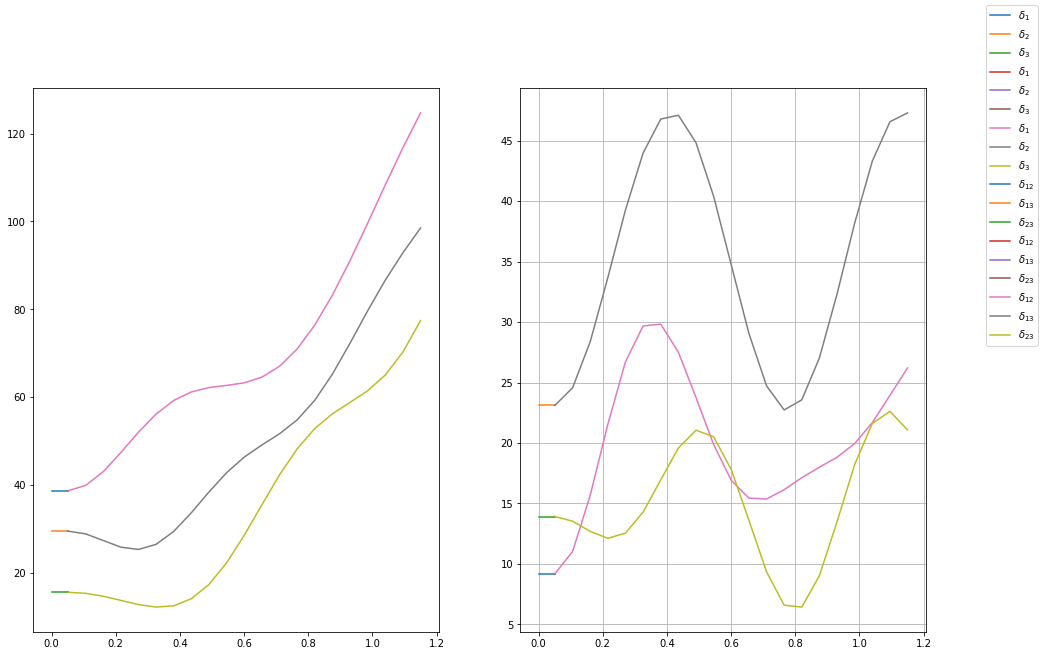

In [192]:
PM1, PM2, PM3 = 1.5, 1, 3
omegaB = 18000
x, y, t = sy.symbols('x,y,t')
dw1,dw2,dw3 = sy.symbols('\Delta\omega_1,\Delta\omega_2,\Delta\omega_3')
pe1,pe2,pe3 = sy.symbols('P_e1,P_e2,P_e3')
dt1,dt2,dt3= sy.symbols('\delta_1, \delta_2, \delta_3')
all_var = (dw1,dw2,dw3,dt1,dt2,dt3,pe1,pe2,pe3)
#稳态开始
deriv_dict_start= {dw1:0,dw2:0,dw3:0,dt1:omegaB*dw1,dt2:omegaB*dw2,dt3:omegaB*dw3,
                   'co_vars':{pe1:pe1-1.5,pe2:pe2-1,pe3:pe3-3},
                   'co_init_values':(1.5,1,3),
                   'init_values':(0,0,0,38.64149,29.44408,15.52411)}
x_stable, y_stable = hiding_trapezium(deriv_dict_start, limit=(0,0.05), n=1)
print(y_stable)
#短路开始
pe1_expr = 0.007093+0.509312*sy.sin((dt1-dt2+3.14997)*sy.pi/180)+0.402458*sy.sin((dt1-dt3+20.21524)*sy.pi/180)
pe2_expr = 0.110463+0.509312*sy.sin((dt2-dt1+3.14997)*sy.pi/180)+1.588518*sy.sin((dt2-dt3+20.21523)*sy.pi/180)
pe3_expr = 2.727604+0.402458*sy.sin((dt3-dt1+20.21524)*sy.pi/180)+1.588518*sy.sin((dt3-dt2+20.21523)*sy.pi/180)
short_init_values = [i[-1] for i in y_stable.values()]
short_dict = dict(zip(all_var, short_init_values))
Pe_short = [float(subs(pe1_expr,short_dict)),
           float(subs(pe2_expr,short_dict)),
           float(subs(pe3_expr,short_dict))]
deriv_dict_short = {dw1:(PM1-pe1)/10,dw2:(PM2-pe2)/7,dw3:(PM3-pe3)/15,
                    dt1:omegaB*dw1,dt2:omegaB*dw2,dt3:omegaB*dw3,
                    "co_vars":{pe1:pe1-pe1_expr,pe2:pe2-pe2_expr,pe3:pe3-pe3_expr},
                    'co_init_values':Pe_short,
                    'init_values':short_init_values[:-3]}
print(deriv_dict_short)
x_short,y_short = hiding_trapezium(deriv_dict_short, limit=(0.05,0.051), n=1)
print(y_short)
#故障切除
pe1_expr_cut = 0.04674+1.307647*sy.sin((dt1-dt2+3.93234)*sy.pi/180)+1.033298*sy.sin((dt1-dt3+20.99761)*sy.pi/180)
pe2_expr_cut = 0.172054+1.307647*sy.sin((dt2-dt1+3.93234)*sy.pi/180)+1.982507*sy.sin((dt2-dt3+20.99761)*sy.pi/180)
pe3_expr_cut = 2.933027+1.033298*sy.sin((dt3-dt1+20.99761)*sy.pi/180)+1.982507*sy.sin((dt3-dt2+20.99761)*sy.pi/180)
cut_init_values = [i[-1] for i in y_short.values()]
cut_dict = dict(zip(all_var, cut_init_values))
Pe_cut = [float(subs(pe1_expr_cut,cut_dict)),
           float(subs(pe2_expr_cut,cut_dict)),
           float(subs(pe3_expr_cut,cut_dict))]
deriv_dict_short = {dw1:(PM1-pe1)/10,dw2:(PM2-pe2)/7,dw3:(PM3-pe3)/15,
                    dt1:omegaB*dw1,dt2:omegaB*dw2,dt3:omegaB*dw3,
                    "co_vars":{pe1:pe1-pe1_expr_cut,pe2:pe2-pe2_expr_cut,pe3:pe3-pe3_expr_cut},
                    'co_init_values':Pe_cut,
                    'init_values':cut_init_values[:-3]}
x_cut,y_cut = hiding_trapezium(deriv_dict_short, limit=(0.051,1.15), n=20)
fig, axes = plt.subplots(1,2,figsize=(16,10))
Delta, Graphs = (dt1,dt2,dt3), ((x_stable,y_stable), (x_short,y_short), (x_cut,y_cut))
for graph in Graphs:
    for delta in Delta:
        axes[0].plot(graph[0], graph[1][delta], label='$'+str(delta)+'$')
    axes[1].plot(graph[0], graph[1][Delta[0]]-graph[1][Delta[1]],label='$\delta_{12}$')
    axes[1].plot(graph[0], graph[1][Delta[0]]-graph[1][Delta[2]],label='$\delta_{13}$')
    axes[1].plot(graph[0], graph[1][Delta[1]]-graph[1][Delta[2]],label='$\delta_{23}$')
#         ax[1].plot(graph[0],)
# plt.plot(x_stable, y_stable[dt1],x_stable, y_stable[dt2],x_stable, y_stable[dt3])
# plt.plot(x_short, y_short[dt1],x_short, y_short[dt2],x_short, y_short[dt3])
# plt.plot(x_cut, y_cut[dt1], x_cut, y_cut[dt2], x_cut, y_cut[dt3])
plt.grid()
fig.legend()
# y = sy.symbols('y')
# deriv = -20*y
# %time x_it, y_it = hiding_trapezium({y:deriv}, limit=(0,1), n=50)
# x_it, y_it = hiding_trapezium({dw:}, limit=(0,1), n=50)

In [117]:
# plt.plot(x_ht,y_ht[delta1],x_ht,y_ht[delta2],x_ht,y_ht[delta3])
# float(sy.cos(90*sy.pi/180))
# expr = 0.007093+0.509312*sy.sin((dt1-dt2+3.14997)*sy.pi/180)+0.402458*sy.sin((dt1-dt3+20.21524)*sy.pi/180)
from scipy.misc import derivative
# print(float(expr.subs({dt1:2,dt2:3,dt3:4})))
dic = {str(i):i for i in range(6)}
dw1,dw2,dw3 = sy.symbols('\Delta\omega_1,\Delta\omega_2,\Delta\omega_3')
all_var = dt1,dt2,dt3
# func = sy.lambdify(all_var, dw1**2+1, "numpy")
# isinstance(func,types.FunctionType)
# a = {pe1:'1'}
# list(a.keys())[0]
# expr = dt1-38.641-0.02*314/2*(dw1+0)
# func = sy.lambdify(all_var, expr, "numpy")
# expr.subs({dt1:1},{dw1:2})
a = np.array([1])
np.concatenate([a,a,a])

array([1, 1, 1])

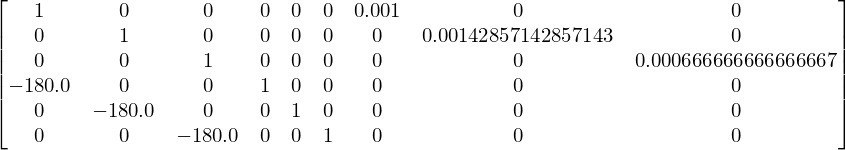

In [106]:
dw1,dw2,dw3 = sy.symbols('\Delta\omega_1,\Delta\omega_2,\Delta\omega_3')
all_var = (dw1,dw2,dw3,dt1,dt2,dt3,pe1,pe2,pe3)
#多维求导！！！
expr = np.array([dt1**2+dt2*dt1,dt2**2+1,dt3**2+1])
diff = sy.diff(expr,np.array((dt1,dt2,dt3)))
diff.tomatrix().T
# A = diff.subs(dict(zip((dt1,dt2,dt3),(1,2,3))))
# print(A)
# A = np.array(A.tomatrix(),dtype=np.float32)
# print(A)
# max(solve(A,np.array([1,1,1])))
sy.diff(np.array([0.001*pe1 + dw1 - 0.00260781681018064,
 0.00142857142857143*pe2 + dw2 - 0.00150257269957879,
 0.000666666666666667*pe3 + dw3 - 0.00207905882942009,
 -180.0*dw1 + dt1 - 38.6415,
 -180.0*dw2 + dt2 - 29.444080352785,
 -180.0*dw3 + dt3 - 15.524109840394]),np.array(all_var)).transpose()

In [193]:
max(abs(np.array([3,5,1]) - np.array([2,3,5])))

4

### 多维lamdify!!! 从而输出值变为array后可以进行矩阵运算！！！

In [ ]:

a = np.array([[1,3],[2,5],[3,6]])
expr = np.array([[dt1**2+1,dt2**2+1],[dt1**2+1,dt2**2+1]])
func = sy.lambdify(all_var, expr,'numpy')
print(np.array(func(*a)))
# %timeit np.array(func(*a))[:,:,1]
np.array(func(*a))[:,:,1] - np.array(func(*a))[:,:,0]

In [180]:
expr = np.array([dt1**2+1,dt2**2+1,dt1**2+1,dt3**2+1])
func = sy.lambdify(all_var, expr,'numpy')
a = np.array([1,2,5])
print(np.array(func(*a)))

[ 2  5  2 26]
